<a href="https://colab.research.google.com/github/GreJerdev/Y-data/blob/master/dl/home_work3/DL_word_embedding_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [1]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup  
import re
import nltk

In [2]:
# Read data from files 
data = pd.read_csv( "lyrics.csv", header=0, delimiter="," )

# Verify the number of row that were read (2,173,422 in total)
print ("Read %d labeled data reviews" % (data.size))
data.head()

Read 2173422 labeled data reviews


,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [106]:
data.genre.unique()

array(['Pop', 'Hip-Hop', 'Not Available', 'Other', 'Rock', 'Metal',
       'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie'],
      dtype=object)

In [4]:
len(data["lyrics"])


362237

In [5]:
# Load the punkt tokenizer

def lyrics_to_wordlist( lyrics, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    lyrics_text = BeautifulSoup(lyrics).get_text()
    #  
    # 2. Remove non-letters
    lyrics_text = re.sub("[^a-zA-Z]"," ", lyrics_text)
    #
    # 3. Convert words to lower case and split them
    words = lyrics_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

# Define a function to split a review into parsed sentences
def lyrics_to_sentences( lyrics, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    if(len(lyrics)== 0):
        return []
    raw_sentences = tokenizer.tokenize(lyrics.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( lyrics_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [6]:
sentences = []  # Initialize an empty list of sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

print ("Parsing sentences from training set")
counter = 0
total_number_of_rows = len(data["lyrics"])
for lyrics in data["lyrics"]:
    counter +=1
    if(lyrics == lyrics):  
        if counter % 1000 == 0:
            print(f'{counter}/{total_number_of_rows}')
        sentences += lyrics_to_sentences(lyrics, tokenizer)

Parsing sentences from training set


/home/g/.local/lib/python3.6/site-packages/bs4/__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


1000/362237
2000/362237
3000/362237
4000/362237
5000/362237
7000/362237
9000/362237
12000/362237
13000/362237
14000/362237
16000/362237
17000/362237
18000/362237
19000/362237
22000/362237


/home/g/.local/lib/python3.6/site-packages/bs4/__init__.py:314: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


25000/362237
26000/362237
27000/362237
29000/362237
33000/362237
34000/362237
36000/362237
37000/362237
38000/362237
40000/362237
42000/362237
43000/362237
44000/362237
45000/362237
46000/362237
47000/362237
48000/362237
50000/362237
53000/362237
54000/362237
56000/362237
57000/362237
58000/362237
61000/362237
62000/362237


/home/g/.local/lib/python3.6/site-packages/bs4/__init__.py:314: UserWarning: "b'/'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


64000/362237
68000/362237
69000/362237
72000/362237
73000/362237
75000/362237
76000/362237
77000/362237
78000/362237
79000/362237
80000/362237
81000/362237
83000/362237
84000/362237
85000/362237
86000/362237
87000/362237
89000/362237
91000/362237
92000/362237
93000/362237
94000/362237
95000/362237
96000/362237
97000/362237
98000/362237
100000/362237
102000/362237
103000/362237
105000/362237
107000/362237
108000/362237
109000/362237
110000/362237
112000/362237
113000/362237
115000/362237
116000/362237
117000/362237
118000/362237
119000/362237
121000/362237
122000/362237
124000/362237
125000/362237
126000/362237
127000/362237
128000/362237
129000/362237
130000/362237
131000/362237
132000/362237
134000/362237
135000/362237
136000/362237
137000/362237
138000/362237
139000/362237
140000/362237
141000/362237
143000/362237
144000/362237
145000/362237
146000/362237
147000/362237
148000/362237


/home/g/.local/lib/python3.6/site-packages/bs4/__init__.py:314: UserWarning: "b'//'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


149000/362237
151000/362237
152000/362237
154000/362237
157000/362237
158000/362237
160000/362237
161000/362237
162000/362237
164000/362237
165000/362237
166000/362237
170000/362237
171000/362237
172000/362237
174000/362237
175000/362237
177000/362237
178000/362237
179000/362237
180000/362237
181000/362237
182000/362237
183000/362237
188000/362237
189000/362237
190000/362237
191000/362237
192000/362237
193000/362237
195000/362237
196000/362237
197000/362237
199000/362237
200000/362237
201000/362237
202000/362237
205000/362237
206000/362237
207000/362237
208000/362237
209000/362237
211000/362237
212000/362237
215000/362237
218000/362237
219000/362237
220000/362237
221000/362237
222000/362237
223000/362237
225000/362237
227000/362237
228000/362237
229000/362237
230000/362237
231000/362237
232000/362237
233000/362237
234000/362237
235000/362237
237000/362237
240000/362237
241000/362237
243000/362237
244000/362237
245000/362237
247000/362237
248000/362237
250000/362237
251000/362237
252000

/home/g/.local/lib/python3.6/site-packages/bs4/__init__.py:314: UserWarning: "b'/.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


298000/362237
300000/362237
301000/362237
302000/362237
303000/362237
304000/362237
305000/362237
306000/362237
307000/362237
308000/362237
309000/362237
310000/362237
311000/362237
312000/362237
315000/362237
316000/362237
319000/362237
320000/362237
321000/362237
323000/362237
325000/362237
329000/362237
330000/362237
331000/362237
332000/362237
333000/362237
336000/362237
339000/362237
340000/362237
341000/362237
342000/362237
343000/362237
345000/362237
346000/362237
348000/362237
349000/362237
350000/362237
352000/362237
353000/362237
354000/362237
355000/362237
356000/362237
357000/362237
358000/362237
360000/362237
361000/362237
362000/362237


In [ ]:
sentences = []  # Initialize an empty list of sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

print ("Parsing sentences from training set")
counter = 0
total_number_of_rows = len(data["lyrics"])
for lyrics in data["lyrics"]:
    counter +=1
    if(lyrics == lyrics):  
        if counter % 1000 == 0:
            print(f'{counter}/{total_number_of_rows}')
        sentences += lyrics_to_sentences(lyrics, tokenizer)

In [7]:
import pickle
# Step 2
with open('sentences.b', 'wb') as config_dictionary_file:
  # Step 3
  pickle.dump(sentences, config_dictionary_file)

['oh', 'baby', 'how', 'you', 'doing']

In [9]:
# Set values for various parameters
num_features = 3000    # Word vector dimensionality                      
min_word_count = 30   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

Training model...


### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [12]:
model.wv.most_similar("country")

[('nashville', 0.4711722135543823),
 ('texas', 0.42542052268981934),
 ('hillbilly', 0.425087571144104),
 ('farm', 0.42091020941734314),
 ('southern', 0.41700053215026855),
 ('tennessee', 0.4128624200820923),
 ('homegrown', 0.40444788336753845),
 ('western', 0.4026687443256378),
 ('illinois', 0.39904969930648804),
 ('carolina', 0.3977320194244385)]

In [13]:
model.wv.most_similar("home")

[('alone', 0.44149452447891235),
 ('back', 0.39174431562423706),
 ('where', 0.36443257331848145),
 ('homesick', 0.3211636543273926),
 ('payphone', 0.3109445571899414),
 ('roam', 0.3012731075286865),
 ('safely', 0.29832303524017334),
 ('phone', 0.2923828363418579),
 ('lonely', 0.28657495975494385),
 ('holidays', 0.2828644812107086)]

In [14]:
model.wv.most_similar("king")

[('kings', 0.529973030090332),
 ('queen', 0.4928017258644104),
 ('crowned', 0.4898328483104706),
 ('ruler', 0.46860259771347046),
 ('rodney', 0.4455219805240631),
 ('luther', 0.43770158290863037),
 ('crowning', 0.42637744545936584),
 ('hong', 0.4263729453086853),
 ('throne', 0.4238130450248718),
 ('simba', 0.411740243434906)]

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [17]:
vector = model.wv['king'] - model.wv['man'] + model.wv['woman']
print(vector)
model.wv.similar_by_vector(vector, topn=10, restrict_vocab=None)

[ 0.04580969 -0.07200838 -0.00492593 ... -0.03154615  0.01647244
 -0.00359621]


[('king', 0.6875251531600952),
 ('queen', 0.46576985716819763),
 ('woman', 0.42273080348968506),
 ('kings', 0.3725214898586273),
 ('crowned', 0.3481811285018921),
 ('princess', 0.3264182209968567),
 ('crown', 0.320339560508728),
 ('goddess', 0.313880980014801),
 ('palace', 0.30315709114074707),
 ('hong', 0.2977418303489685)]

In [20]:
cosine_distance = model.wv.similarity("car", "plan")
print("Cosine distance = ", cosine_distance)

euclidean_distance = np.linalg.norm(model.wv["car"] - model.wv["plan"])
print("Euclidean distance = ", euclidean_distance)

Cosine distance =  0.030345669
Euclidean distance =  1.3925906


## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [63]:
scl_opp = pd.read_csv( "SCL-OPP.txt",header=None, delimiter="\t")

# Verify the number of row that were read (2,173,422 in total)
print ("Read %d labeled data reviews" % (scl_opp.size))
scl_opp.head()

tokens_dic = {}

for i in range(scl_opp.shape[0]):
    tokens_dic[scl_opp.iloc[i][0]] = scl_opp.iloc[i][1]



Read 4712 labeled data reviews


In [66]:
#All the words in our lyrics corpus
vocab =  list(model.wv.vocab.keys())
#All the words shared between the sentiment lexicon and our lyrics corpus.
lexicon_words = []
for key,value in tokens_dic.items():
    if key in vocab:
        lexicon_words.append([key,value])
lexicon = pd.DataFrame(lexicon_words, columns=["word","sentiment"])
lexicon.head()

,word,sentiment
0,amazing,1.000
1,love,0.969
2,smiling,0.953
3,wonderful,0.953
4,happiness,0.938


Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression


w2vector = model[lexicon.word]
X_train, X_test, y_train, y_test = train_test_split(w2vector,lexicon.sentiment, test_size = 0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)
print("Train Score: {}, Test Score {}".format(mse(lr.predict(X_train),y_train),mse(lr.predict(X_test),y_test)))

/home/g/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


Train Score: 3.548735396530034e-12, Test Score 0.33717765845892406


In [78]:
#the next part will be to use our lr model to predict sentiment score for any word embeddings
not_in_lexicon = []
for word in vocab:
    if word not in lexicon['word'].values:
        not_in_lexicon.append(word)

values = lr.predict(model[not_in_lexicon])

sents_df = pd.DataFrame((not_in_lexicon, values)).T
sents_df.columns = ["word","sentiment"]
sents_df.Sentiment = sents_df.sentiment / max(np.abs(sents_df.sentiment))

/home/g/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/home/g/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()


In [80]:
sents_df.sort_values(by="sentiment")

,word,sentiment
16338,dismayed,-2.15712
2998,stalking,-2.09456
4326,bastard,-2.05636
22901,brung,-2.0045
4129,snitch,-1.98548
...,...,...
30275,ohoho,2.05039
30367,schlau,2.05304
629,enjoy,2.05487
5018,trim,2.19221


### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [ ]:
genres = {genre:[] for genre in data.genre.unique()}
# 'Pop', 'Hip-Hop', 'Not Available', 'Other', 'Rock', 'Metal',
#       'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie'
by_genres = data.groupby(['genre'])["lyrics"].apply(list)
for genre in data.genre.unique():
    genres[genre]= set(lyrics_to_wordlist(' '.join(map(str, by_genres[genre]))))

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [102]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 3000), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 3000 to 50 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

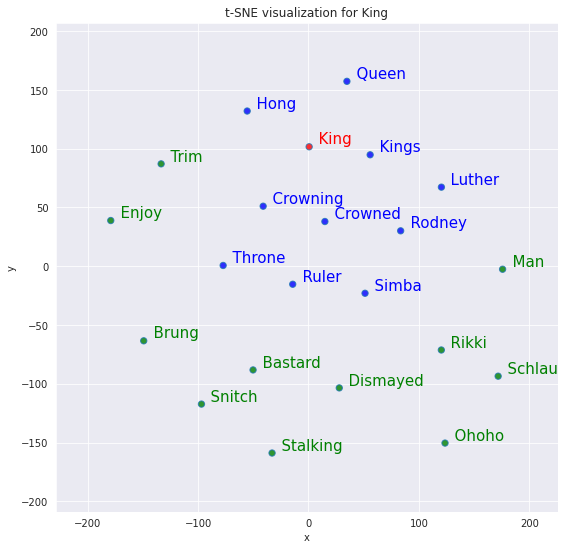

In [103]:



tsnescatterplot(model, 'king', ['man','dismayed',  'stalking', 'bastard',  'brung','snitch','ohoho','schlau', 'enjoy','trim','rikki'])

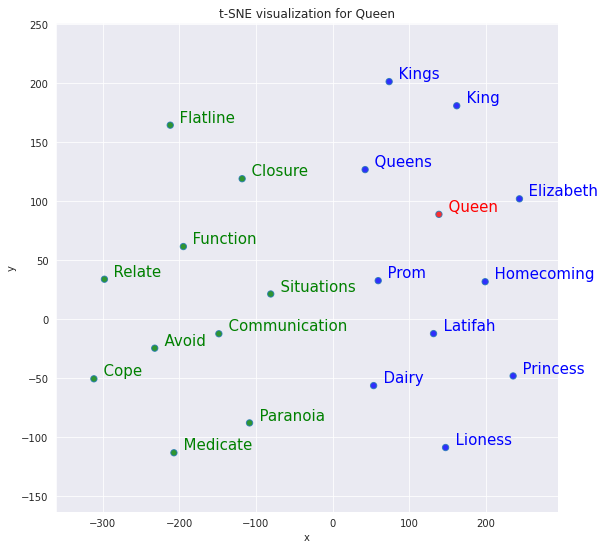

In [104]:
tsnescatterplot(model, 'queen', [i[0] for i in model.wv.most_similar(negative=["queen"])])

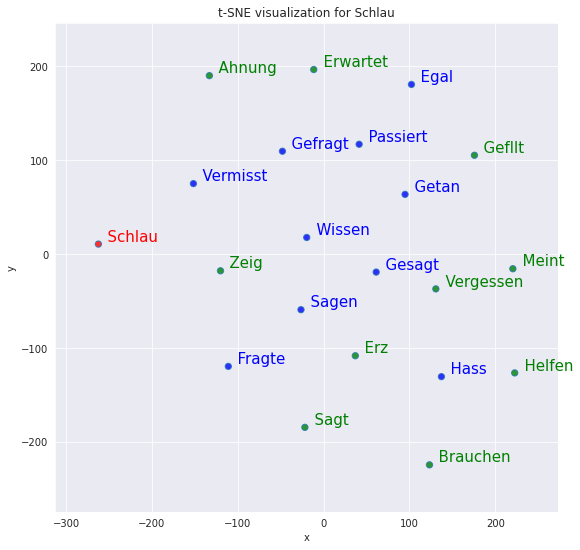

In [108]:
tsnescatterplot(model, "schlau", [t[0] for t in model.wv.most_similar(positive=["schlau"], topn=20)][10:])

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

Show the confusion matrix.

Show the classification report - precision, recall, f1 for each class.

### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.